# Acoustic Project

In this notebook,
we test the efficiency of several automatic learning models in predicting the localization of a person in a living room based on the sound measured on several microphones.
This project is based on the article “SOUNDCAM: A Dataset for Finding Humans Using Room Acoustics”.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

## Initialization

We start by setting up our datasets and parameters so we can have the same basis in the training of every model we handle.
The dataset can be found in the folders 'Human1' and 'Human2',
which represent two different humans in the same living room environment.

### Room Impulse Response (RIR)

The RIR represents the acoustic properties of a room or environment.
It captures how sound is reflected, absorbed, and diffracted by various surfaces and objects within the room.
The RIR is obtained by recording the response of the room to an impulse or short burst of sound.  
We load the RIR stored in the files 'deconvoled_trim.npy' in the folders 'Human1' and 'Human2',
and we combine them in a single dataset.
The content of this dataset will be used to create the inputs for each model.

In [2]:
rirs_1 = np.load('../Acoustic-IA-Data-Hack-2024/data/LivingRoom_preprocessed_hack/Human1/deconvoled_trim.npy')
rirs_2 = np.load('../Acoustic-IA-Data-Hack-2024/data/LivingRoom_preprocessed_hack/Human2/deconvoled_trim.npy')
rirs = np.append(rirs_1, rirs_2, axis=0)

### Localizations

The output of our models will be the coordinates of a person in a room.
In order to train and test these models,
we load the contents of the files 'centroid.npy' in the folders 'Human1' and 'Human2' into a single dataset.

In [3]:
localizations_1 = np.load('../Acoustic-IA-Data-Hack-2024/data/LivingRoom_preprocessed_hack/Human1/centroid.npy')
localizations_2 = np.load('../Acoustic-IA-Data-Hack-2024/data/LivingRoom_preprocessed_hack/Human2/centroid.npy')
localizations = np.append(localizations_1, localizations_2, axis=0)

In [4]:
# Initialise the base parameters for the training
test_size = 0.2
seed = 42

### Result interpretation

In order to understand the results we are given by our models,
we use the mean distance between the expected results and the ones we were given from our testing set.
This distance, defined below, is given in centimeters with a precision of 1 behind the floating point.

In [5]:
def distance(actual, expected):
    diff_x = actual[:, 0] - expected[:, 0]
    diff_y = actual[:, 1] - expected[:, 1]
    return np.sqrt(np.square(diff_x) + np.square(diff_y))

def mean_distance(actual, expected):
    return round(distance(actual, expected).mean(), 0) / 10

## The k-Nearest Neighbors and Linear Regression models

### Root Mean Square (RMS)

RMS is a statistical measure that represents the effective value of a varying quantity, such as an audio signal. 
It is often used to describe the perceived loudness of an audio signal.

In the kNN and Linear Regression models, the RMS is used to reduce the amount of data given as an input.
The code below creates the training and testing sets for these models after calculating the RMS measured by each microphone in the room to use them as inputs instead of the RIRs.

In [6]:
rms = np.sqrt(np.square(rirs).mean(axis=2))
X_train, X_test, y_train, y_test = train_test_split(rms, localizations, test_size=test_size, random_state=seed)

### Implementation of Linear Regression

The implementation of the Linear Regression model is straightforward,
since there are no parameters to take care of.

In [7]:
reg = LinearRegression()
reg.fit(X_train, y_train)
print(f"mean distance: {mean_distance(reg.predict(X_test), y_test)} cm")

mean distance: 149.5 cm


### Implementation of k-Nearest Neighbors

The efficiency of the kNN model depends on the number of neighbors it takes into account during its predictions.
Therefore, we test said efficiency with a number of neighbors ranging from 2 to 9, and select the one with the smallest mean distance to the expected coordinates.

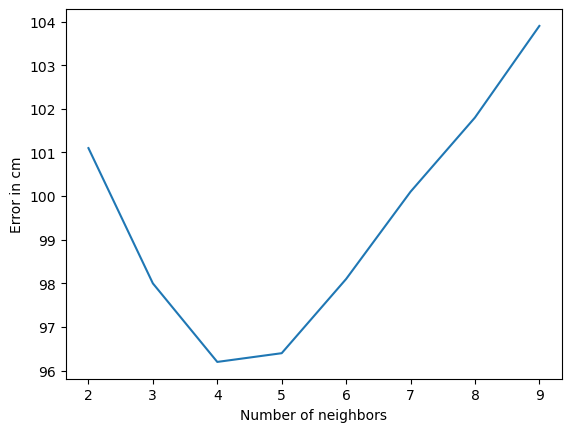

In [8]:
nb_neighbors = []
mean_distance_list = []
for i in range(2, 10):
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(X_train, y_train)
    nb_neighbors.append(i)
    mean_distance_list.append(mean_distance(knn.predict(X_test), y_test))

plt.xlabel("Number of neighbors")
plt.ylabel("Error in cm")
plt.plot(nb_neighbors, mean_distance_list)
plt.show()

The graph shown above is a U-shaped curve with a minimal value when using 4 neighbors.
Indeed, when the number of neighbors increases over 4,
the model tends to over generalize in its predictions, which causes it to have bigger errors overall.

In [9]:
knn = KNeighborsRegressor(n_neighbors=4)
knn.fit(X_train, y_train)
print(f"mean distance: {mean_distance(knn.predict(X_test), y_test)} cm")

mean distance: 96.2 cm


### Truncating the inputs

The sound given as inputs so far were taken from samples of 14 seconds of sound.
Therefore, these samples may contain noise due to reverb for example.

In order to see the impact the sample size may have,
we test the kNN and the Linear Regression models with samples representing only 2 seconds of sound.

In [10]:
# Selecting the first 96000 values for each microphone, because the sound was saved at 48kHz
rms = np.sqrt(np.square(rirs[:, :, :96000]).mean(axis=2))
normalized_rms = (rms - np.mean(rms)) / np.std(rms)

X_train, X_test, y_train, y_test = train_test_split(normalized_rms, localizations, test_size=test_size, random_state=seed)

In [11]:
reg = LinearRegression()
reg.fit(X_train, y_train)
print(f"mean distance: {mean_distance(reg.predict(X_test), y_test)} cm")

mean distance: 149.4 cm


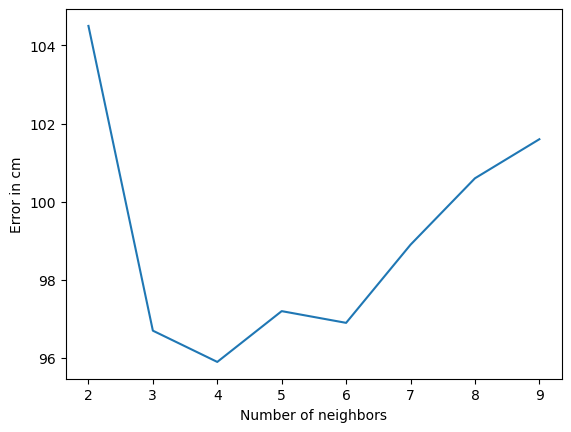

In [12]:
nb_neighbors = []
mean_distance_list = []
for i in range(2, 10):
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(X_train, y_train)
    nb_neighbors.append(i)
    mean_distance_list.append(mean_distance(knn.predict(X_test), y_test))

plt.xlabel("Number of neighbors")
plt.ylabel("Error in cm")
plt.plot(nb_neighbors, mean_distance_list)
plt.show()

In [13]:
knn = KNeighborsRegressor(n_neighbors=4)
knn.fit(X_train, y_train)
print(f"mean distance: {mean_distance(knn.predict(X_test), y_test)} cm")

mean distance: 95.9 cm
